# Deact Model - Comparing Different Model Options
### Imports

In [1]:
import deact
from datetime import datetime
from pyspark.sql import SparkSession
from IPython.display import display, Image

### SparkSession

In [2]:
warehouse_location = 'hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/grp_gdoop_clv_hiveDB.db'
python_location = './ANACONDA/anaconda2_env/bin/python'
archives_location = 'hdfs:////user/grp_gdoop_admin/anaconda/anaconda2_env.zip#ANACONDA'

spark = SparkSession\
    .builder\
    .master('yarn')\
    .appName('deact-model')\
    .config('spark.submit.deployMode','client')\
    .config('spark.executor.instances', 50)\
    .config('spark.yarn.appMasterEnv.PYSPARK_PYTHON',python_location)\
    .config('spark.yarn.dist.archives',archives_location)\
    .config('spark.sql.warehouse.dir',warehouse_location)\
    .config('spark.yarn.queue','public')\
    .enableHiveSupport()\
    .getOrCreate()

spark

### Parameters

In [3]:
train_date = '2018-11-10'
score_date = None
train_pct = 0.10
validate_pct = 0.10
validate_model = True
score_active_users = False
save_results = True

### Start Workflow
- Print workflow information
- Load data

In [4]:
# Print workflow information
print('\n[ ' + str(datetime.utcnow()) + ' ] : Beginning DEACT MODEL pipeline with parameters:\n')
print('\tTraining date = ' + train_date)
print('\tProportion of training data used to:')
print('\t\tTrain model = ' + str(int(train_pct * 100)) + '%')

if validate_model:
    print('\t\tValidate model = ' + str(int(validate_pct * 100)) + '%')
    print('\t\tNot used = ' + str(int((1 - train_pct - validate_pct) * 100)) + '%')
else:
    print('\t\tValidate model = 0%')
    print('\t\tNot used = ' + str(int((1 - train_pct) * 100)) + '%')

if score_active_users:
    print('\tScoring date = ' + score_date)
else:
    print('\tNot making predictions on scoring data')

# Save locations
hdfs_loc = 'hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/deact-model/'
eval_path = '/home/ceasterwood/Consumer-Intelligence/Models/Deact-Model/model_selection/model_evaluation/'

# Run data pipeline
pl = deact.Pipeline(spark, train_date, score_date, train_pct, validate_pct)
dfs = pl.run(validate_model, score_active_users)


[ 2019-11-12 01:54:03.946130 ] : Beginning DEACT MODEL pipeline with parameters:

	Training date = 2018-11-10
	Proportion of training data used to:
		Train model = 10%
		Validate model = 10%
		Not used = 80%
	Not making predictions on scoring data

DATA PIPELINE

[ 2019-11-12 01:54:03.948677 ] : Loading training feature data
[ 2019-11-12 01:54:09.429627 ] : Splitting training data into model training and validation data
[ 2019-11-12 01:54:11.216853 ] : Creating feature engineering pipeline
[ 2019-11-12 01:56:22.310154 ] : Feature engineering model training data
[ 2019-11-12 01:56:23.479124 ] : Feature engineering model validation data


### Models to Test

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier

params = {'labelCol': 'deactivated', 'featuresCol': 'features',
          'maxDepth': 6, 'minInstancesPerNode': 500, 'subsamplingRate': 0.5,
          'numTrees': 1000, 'maxIter': 20}
models = [
    {
        'name': 'random_forest',
        'train_df': dfs['training'],
        'features': dfs['features'],
        'classifier': RandomForestClassifier(
            labelCol=params['labelCol'],
            featuresCol=params['featuresCol'],
            maxDepth=params['maxDepth'],
            minInstancesPerNode=params['minInstancesPerNode'],
            subsamplingRate=params['subsamplingRate'],
            numTrees=params['numTrees'],
        ),
        'validate_df': dfs['validation'],
    },
    {
        'name': 'gradient_boosted_trees',
        'train_df': dfs['training'],
        'features': dfs['features'],
        'classifier': GBTClassifier(
            labelCol=params['labelCol'],
            featuresCol=params['featuresCol'],
            maxDepth=params['maxDepth'],
            minInstancesPerNode=params['minInstancesPerNode'],
            subsamplingRate=params['subsamplingRate'],
            maxIter=params['maxIter'],
        ),
        'validate_df': dfs['validation'],
    },
    {
        'name': 'gbt_1_feature',
        'train_df': VectorAssembler(inputCols=['recency_x'], outputCol='recency_feature', handleInvalid='keep')
            .transform(dfs['training']),
        'features': ['recency_x'],
        'classifier': GBTClassifier(
            labelCol=params['labelCol'],
            featuresCol='recency_feature',
            maxDepth=params['maxDepth'],
            minInstancesPerNode=params['minInstancesPerNode'],
            subsamplingRate=params['subsamplingRate'],
            maxIter=params['maxIter'],
        ),
        'validate_df': VectorAssembler(inputCols=['recency_x'], outputCol='recency_feature', handleInvalid='keep')
            .transform(dfs['validation']),
    },
]

### Continue Workflow
- Train models
- Make predictions
- Evaluate predictions

In [6]:
# Train models, make predictions on validation data, and evaluate predictions
model_collection = []
for m in models:
    model = deact.Model(train_date, score_date, m['name'], m['classifier'], m['features'])
    model.train(m['train_df'])
    model.predict(m['validate_df'], 'validation', save_results, hdfs_loc)
    model.evaluate(save_results, eval_path)
    model_collection.append(model)

# Create plots comparing results from all models
plots = deact.Plotting(model_collection, save_results, eval_path)
plots.create()

print('\n[ ' + str(datetime.utcnow()) + ' ] : Completed DEACT MODEL pipeline\n')


MODELING

[ 2019-11-12 01:59:23.826276 ] : Training model = random_forest

PREDICTING DEACTIVATIONS

[ 2019-11-12 02:32:26.643021 ] : Making predictions on validation data for model = random_forest
[ 2019-11-12 02:32:26.793082 ] : Saving validation predictions to cerebro for model = random_forest
[ 2019-11-12 02:36:38.388166 ] : Deact probabilities stored in hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/deact-model/ce_keep_deact_predictions1/record_date=2018-11-10/model=random_forest

EVALUATING MODEL

[ 2019-11-12 02:36:38.388794 ] : Calculating count matrix for predictions from model = random_forest
[ 2019-11-12 02:36:55.341496 ] : Calculating performance by class for model = random_forest
[ 2019-11-12 02:36:55.347891 ] : Calculating recency aggregations for predictions by model = random_forest
[ 2019-11-12 02:37:37.281710 ] : Calculating probability calibration for model = random_forest
[ 2019-11-12 02:37:48.224416 ] : Calculating feature importances for model = random_forest

In [7]:
model_collection

[<Model(name=random_forest, train_date=2018-11-10)>,
 <Model(name=gradient_boosted_trees, train_date=2018-11-10)>,
 <Model(name=gbt_1_feature, train_date=2018-11-10)>]

In [8]:
plots

<Plotter(num_models=3, model_collection=[<Model(name=random_forest, train_date=2018-11-10)>, <Model(name=gradient_boosted_trees, train_date=2018-11-10)>, <Model(name=gbt_1_feature, train_date=2018-11-10)>])>

### Model Summaries

In [9]:
for m in model_collection:
    print('\nMODEL: '+m.name)
    display(m.count_df)
    display(m.eval_df)


MODEL: random_forest


,predicted_0,predicted_1,total
actual_0,552601,531884,1084485
actual_1,199471,1697000,1896471
total,752072,2228884,2980956


,N,precision,recall,f1,predOverActualN
0,1084485,0.734771,0.509552,0.601779,0.693483
1,1896471,0.761368,0.894820,0.822717,1.175280
weighted,2980956,0.751692,0.754658,0.742339,1.000000



MODEL: gradient_boosted_trees


,predicted_0,predicted_1,total
actual_0,629729,454756,1084485
actual_1,261611,1634860,1896471
total,891340,2089616,2980956


,N,precision,recall,f1,predOverActualN
0,1084485,0.706497,0.580671,0.637434,0.821902
1,1896471,0.782373,0.862054,0.820283,1.101844
weighted,2980956,0.754769,0.759685,0.753762,1.000000



MODEL: gbt_1_feature


,predicted_0,predicted_1,total
actual_0,543377,541108,1084485
actual_1,354006,1542465,1896471
total,897383,2083573,2980956


,N,precision,recall,f1,predOverActualN
0,1084485,0.605513,0.501046,0.548348,0.827474
1,1896471,0.740298,0.813334,0.775099,1.098658
weighted,2980956,0.691263,0.699723,0.692606,1.000000


### Display Plots

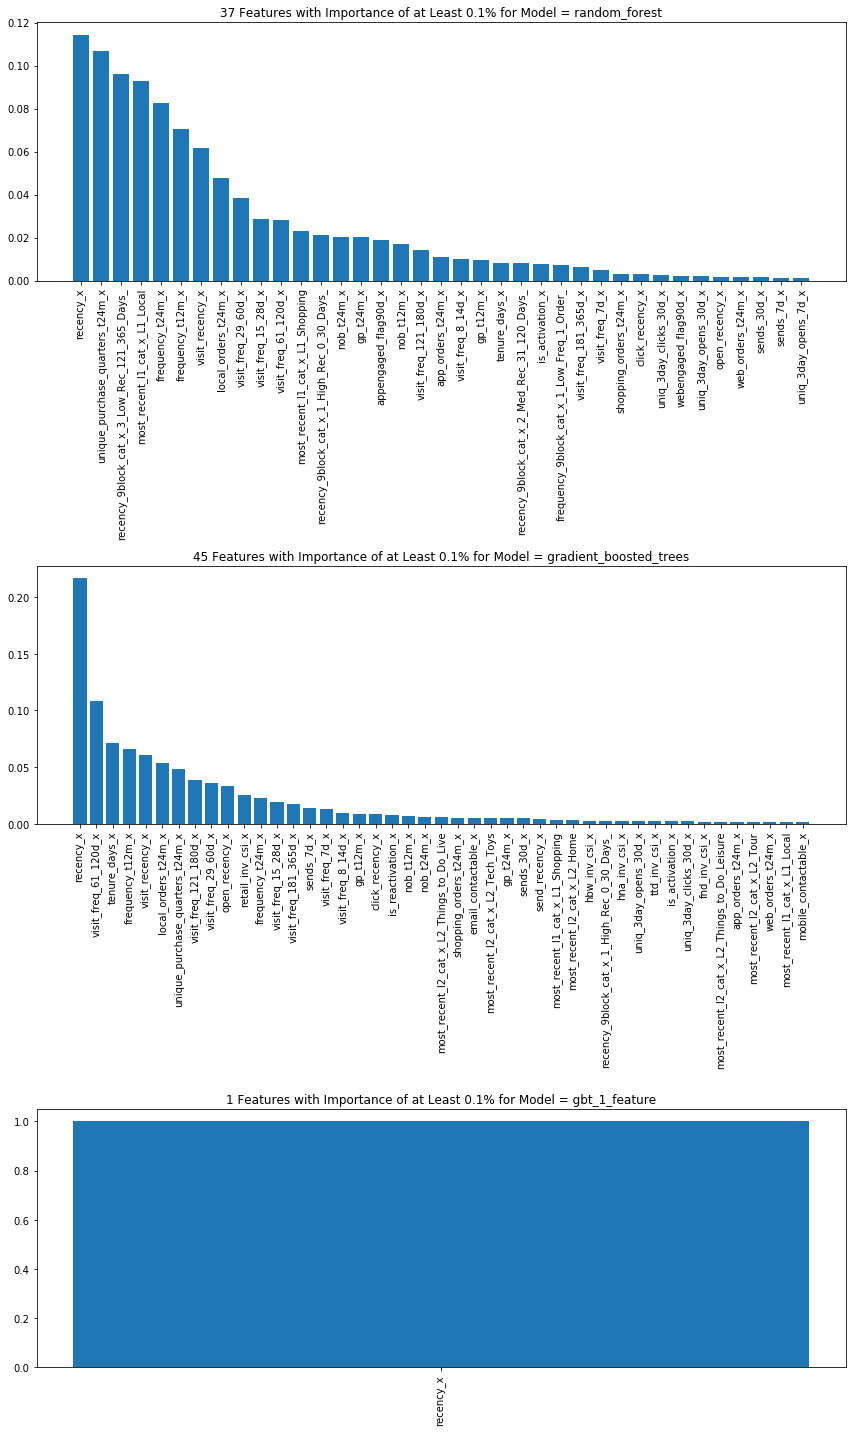

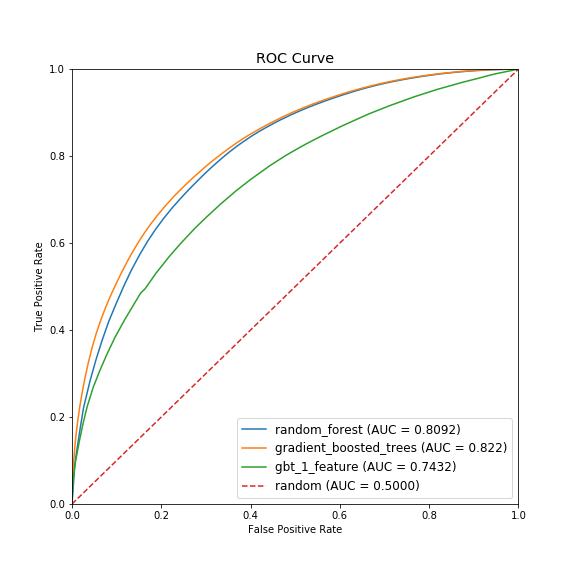

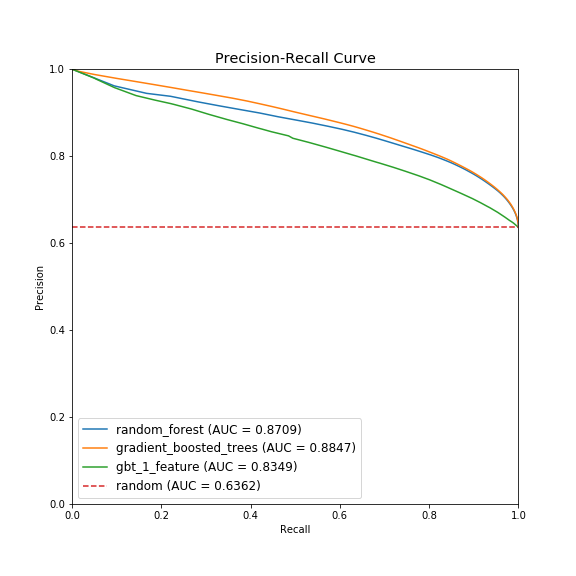

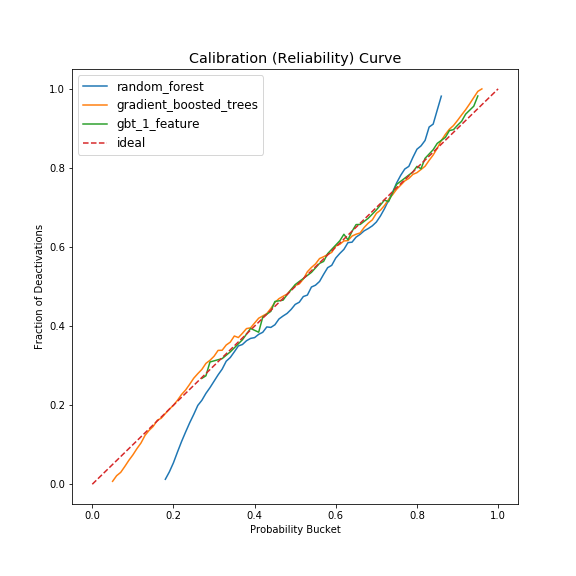

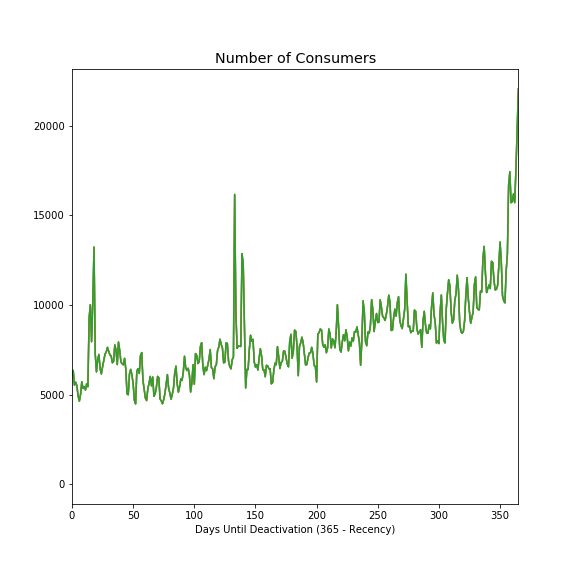

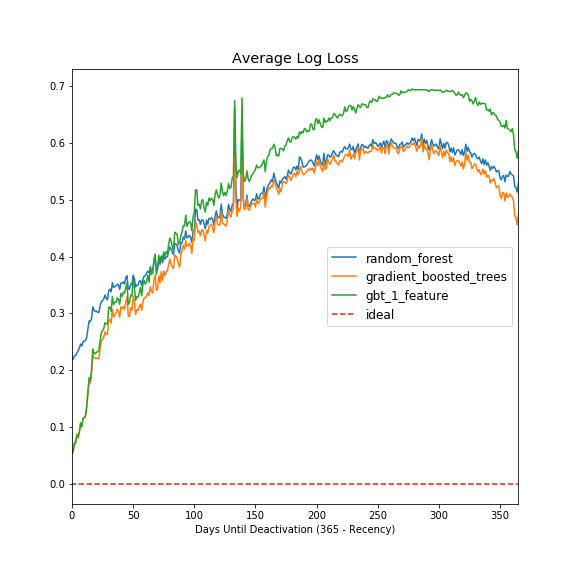

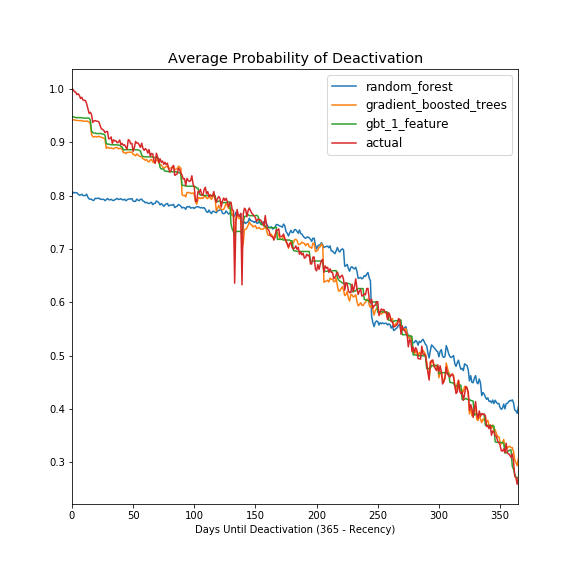

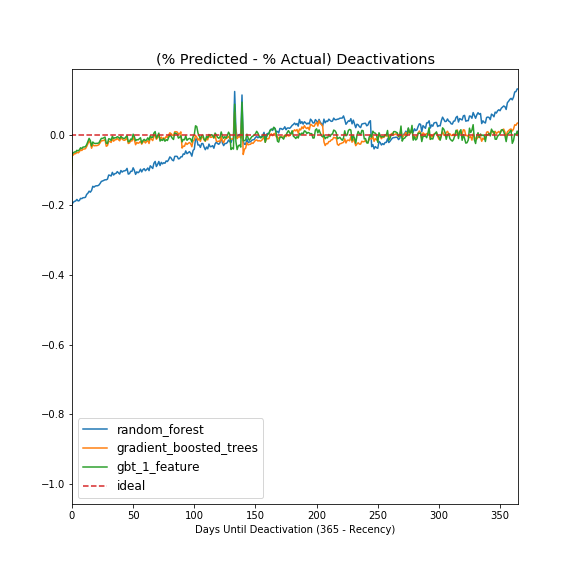

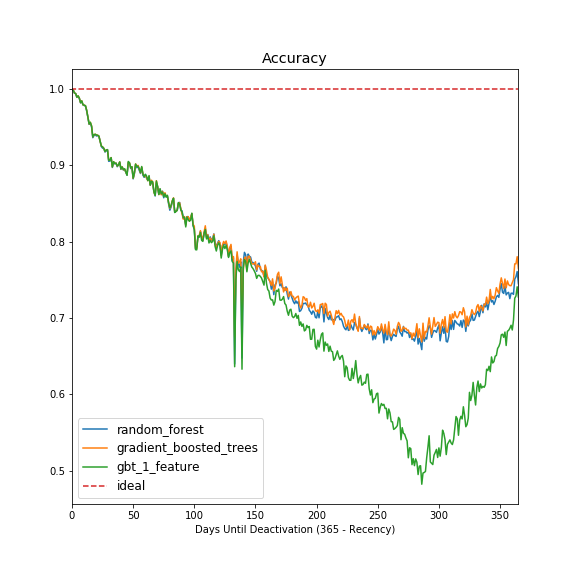

In [11]:
plot_names = ['feat_imp','roc','pr','calibration',\
              'count_users','avg_log_loss','avg_prob_deact',\
              'diff_pct_deact','accuracy']

for p in plot_names:
    display(Image('model_evaluation/plot_'+p+'.png'))